In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

import pickle
from copy import deepcopy

import os, sys
import json
import datetime
import networkx as nx


# Definitions and Data Loading

In [48]:
input_path = 'data'
OUT_FOLDER = 'data'
SAVE_IMAGES = False

In [49]:
# Time that is added to the latency each time it reaches a node that is not the target (servisers node)
HOP_TIME_MS = 50.  # [ms]
LATENCY_METRIC = 'median_success_latency' # 'weighted_success_latency'

In [50]:
# Read cloud ping data
columns_ping_data = np.genfromtxt(os.path.join(input_path, 'cloudping_p50_1W_02-02-2023.csv'), delimiter=",", usecols=(0), dtype=str)
columns_ping_data = [a.split(' ')[-1] for a in columns_ping_data]
ping_data = np.genfromtxt(os.path.join(input_path, 'cloudping_p50_1W_02-02-2023.csv'), delimiter=",")[:,1:]
# Create dictionaries for column to index conversion
loc_ping_dict = { i : a for a, i in enumerate(columns_ping_data)}
loc_ping_dict_inv = { a : i for a, i in enumerate(columns_ping_data)}

Historical data from:
2022-11-08T06:19:16.000000000
to:
2023-01-03T06:04:44.000000000


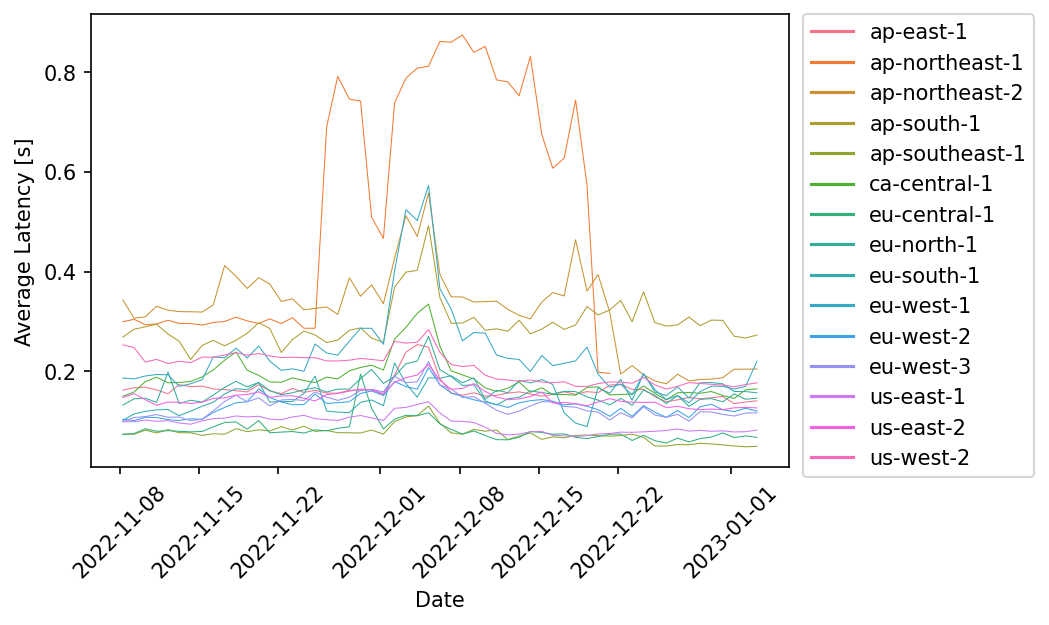

In [51]:
# Read historical latency data by gateway
data_df = pd.read_csv(os.path.join(input_path, 'historical_data.csv'), index_col=0)
data_df['date'] = data_df['date'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

print('Historical data from:')
print(data_df.head(1)['date'].values[0])
print('to:')
print(data_df.tail(1)['date'].values[0])

# Plot Historical data
fig = plt.figure(dpi=150)
plot_ = sns.lineplot(x='date', y=LATENCY_METRIC, data=data_df, hue="gateway", linewidth=0.5)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Average Latency [s]')
plt.xlabel('Date')
plt.xticks(rotation=45)

if SAVE_IMAGES:
    plt.draw()
    img_path = os.path.join(OUT_FOLDER, "hist_latency.png")
    fig.savefig(img_path, bbox_inches="tight")

plt.show()

plt.close(fig) 




# Pre Process Data

In [52]:
# Average historical data over the observed period
grouped_df = data_df.groupby('gateway').agg({'median_success_latency' : "mean", 
                                             'weighted_success_latency' : "mean", 
                                             'p_90_latency' : "mean", 
                                             'success_rate' : "mean",  
                                             'total_success' : "sum"}).reset_index()
grouped_df

,gateway,median_success_latency,weighted_success_latency,p_90_latency,success_rate,total_success
0,ap-east-1,0.163512,0.229177,0.241171,0.991958,3075791944
1,ap-northeast-1,0.534434,0.778632,0.855377,0.955993,4246159791
2,ap-northeast-2,0.322403,0.403431,0.445752,0.993367,3225781873
3,ap-south-1,0.295218,0.376591,0.427422,0.994029,407696173
4,ap-southeast-1,0.075212,0.108063,0.118408,0.993959,11016826483
5,ca-central-1,0.185682,0.238066,0.266844,0.996725,521897913
6,eu-central-1,0.081806,0.123698,0.150011,0.993848,13848272493
7,eu-north-1,0.161218,0.231729,0.262870,0.994851,2015247834
8,eu-south-1,0.152917,0.212740,0.260691,0.993368,943586648
9,eu-west-1,0.234468,0.273765,0.330305,0.997189,162269559


In [53]:
# Calculate the average latency of the current deployment
current_avg_latency = ((grouped_df[LATENCY_METRIC]*grouped_df['total_success']).sum()/grouped_df['total_success'].sum())*1000.
print('Current average latency: %0.2f ms'%current_avg_latency)


Current average latency: 155.66 ms


### Construct NetworkX Graph

In [54]:
# Get number of gateways (actually the number of AWS AZs, they are all portential gateways)
num_gateways = ping_data.shape[0]
# Create full graph
gateways_graph = nx.complete_graph(num_gateways)
# Add names to nodes
for node in gateways_graph.nodes:
    gateways_graph.nodes[node]['name'] = loc_ping_dict_inv[node]
    traffic_here = grouped_df.loc[grouped_df['gateway'] == loc_ping_dict_inv[node]]['total_success'].values
    if len(traffic_here) == 0:
        gateways_graph.nodes[node]['traffic'] = 0
    else:
        gateways_graph.nodes[node]['traffic'] = traffic_here[0]
# For each node add the ping to all other locations
attrs = dict()
for x in range(num_gateways):
    for y in range(num_gateways):
        attrs[(x, y)] = {"ping" : ping_data[x,y], "weight" : ping_data[x,y], "inv_weight" : 1/ping_data[x,y]}
nx.set_edge_attributes(gateways_graph, attrs)
# Keep copy base network, this is used to create each search point
gateways_graph_base = deepcopy(gateways_graph) 
# Add a new node representing the servisers
servisers_node = num_gateways 
for i, row in grouped_df.iterrows():
    # Get target node
    taeget_node = loc_ping_dict[row['gateway']]
    # Set new edge
    gateways_graph.add_edge(taeget_node, servisers_node,
        median_success_latency  = row['median_success_latency'],
        weighted_success_latency =  row['weighted_success_latency'],
        p_90_latency = row['p_90_latency'],
        success_rate = row['success_rate'],
        weight = (row[LATENCY_METRIC]*1000.), # Convert from [s] to [ms]
        inv_weight = 1/(row[LATENCY_METRIC]*1000.) # This is used for plotting
        )
gateways_graph.nodes[servisers_node]['name'] = 'servicers'
gateways_graph.nodes[servisers_node]['traffic'] = 1e10 # Used for plotting, no effect in model


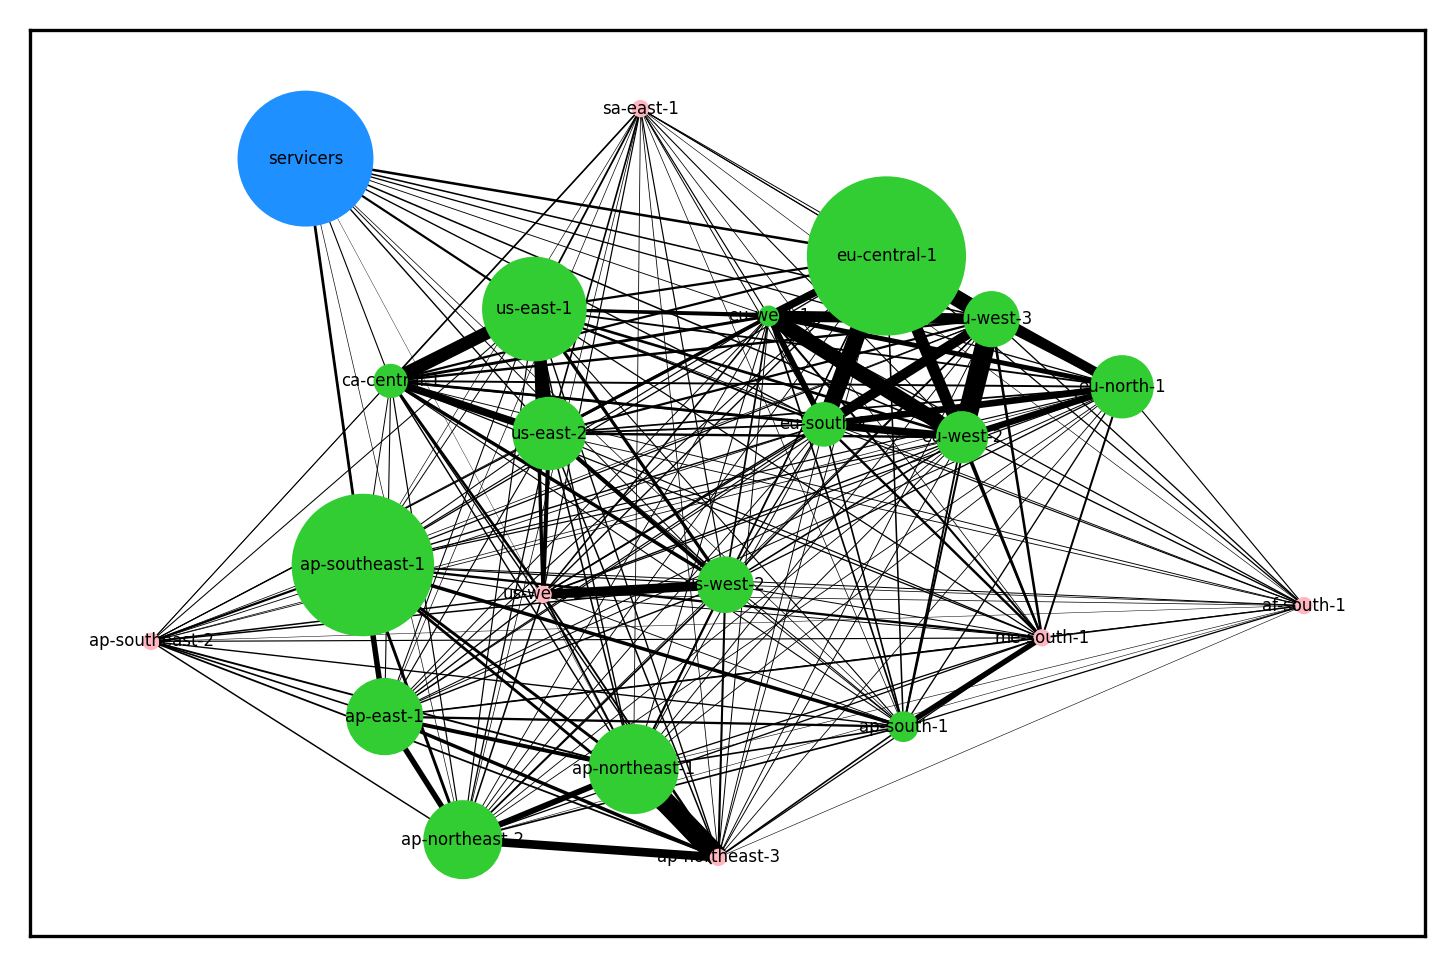

In [55]:
# Plot Network
# (lots of code only for beautification)
node_colors = ['limegreen' if gateways_graph.nodes[node]['traffic'] != 1e10 else 'dodgerblue' for node in gateways_graph.nodes] 
node_colors = [node_colors[node] if (gateways_graph.nodes[node]['traffic'] > 0) else 'lightpink' for node in gateways_graph.nodes] 
node_sizes = [gateways_graph.nodes[node]['traffic'] for node in gateways_graph.nodes]
node_sizes = [node_sizes[node] if (gateways_graph.nodes[node]['traffic'] > 0) else 1e8 for node in gateways_graph.nodes] 
node_sizes = [node_sizes[node]/1e7 for node in gateways_graph.nodes] 

edge_width_mult = 50.
edge_widths = list()
for e in gateways_graph.edges:
    edge_widths.append((1./gateways_graph.get_edge_data(e[0], e[1])['weight'])*edge_width_mult)

labels = dict()
for node in gateways_graph.nodes:
    labels[node] = gateways_graph.nodes[node]['name']

fig = plt.figure(dpi=300)
if os.path.exists(os.path.join(OUT_FOLDER, "pos_draw.pkl")):
    # Reload positions used for document creation
    with open(os.path.join(OUT_FOLDER, "pos_draw.pkl"), "rb") as f:
        pos_draw = pickle.load(f)
else:
    # Create a new one
    pos_draw = nx.spring_layout(gateways_graph, threshold=0.0001, weight='inv_weight', iterations=100)
nx.draw_networkx(gateways_graph, 
                 pos=pos_draw, 
                 labels=labels, 
                 node_size=node_sizes,
                 node_color=node_colors, 
                 width=edge_widths, 
                 with_labels=True, 
                 font_size=4)
if SAVE_IMAGES:
    plt.box(False)
    plt.draw()
    img_path = os.path.join(OUT_FOLDER, "network_current.png")
    fig.savefig(img_path, bbox_inches="tight")

plt.show()

plt.close(fig) 


# Search Throug Brute Force

In [56]:
# Get matrix of all relays
relays_gateway = np.zeros((num_gateways+1))
for i, node in enumerate(gateways_graph_base.nodes):
    relays_gateway[i] = gateways_graph_base.nodes[node]['traffic']
mean_relays = np.mean(relays_gateway)
# Normalize (numeric stability)
relays_gateway = relays_gateway/mean_relays
all_relays = np.sum(relays_gateway)

# --- Create a list of lists of gateways to activate
gateways_max_deploy = 6
gw_list = list()
lat_dict = dict()
for i, row in grouped_df.iterrows():
    gw_list.append(loc_ping_dict[row['gateway']])
    lat_dict[loc_ping_dict[row['gateway']]] = row[LATENCY_METRIC]*1000.
gw_list = np.array(gw_list)    
# List of lists of active gateways
def gen_search_space(lista_fill, lista_source, indexes_running, level, stop):
    ''' Recursive solution for convinatory search without replacement
    '''
    if len(lista_fill) == 0:
        # Setup
        lista_fill = [list() for a in range(stop)]

    if len(indexes_running) == 0:
        init_idx = 0
    else:
        init_idx = indexes_running[-1]+1

    for i in range(init_idx, len(lista_source)):
        aux_list = [lista_source[a] for a in indexes_running]
        aux_list.append(lista_source[i])
        lista_fill[level].append(aux_list)

        # If this is not the last requested level, open a new one
        if (level+1) != stop:
            indexes_running_next = deepcopy(indexes_running)
            indexes_running_next.append(i)
            gen_search_space(lista_fill, lista_source, indexes_running_next, level+1, stop)
    
    return lista_fill

all_lists = gen_search_space(list(), gw_list, list(), 0, 6)

# Names of the gateways groups
all_names = ['Deploying_%d_gateways'%(i+1) for i in range(gateways_max_deploy)]

# Custom weighting function for the edge weighting. 
# This adds hops time to the shortest path search.
def custom_edge_cost(u, v, attr, target_node=servisers_node, hop_cost_base = HOP_TIME_MS):
    hop_cost = 0 if ((u == target_node) or (v == target_node)) else hop_cost_base
    return (attr['weight'] + hop_cost)


In [57]:
best_of_list = dict()
for this_list, this_name in zip(all_lists, all_names):

    print('Analyzing case: %s'%this_name)

    # All combinantions of gateways in this case
    this_list_costs = list()
    for gw_on in this_list:

        aux_G = deepcopy(gateways_graph_base)

        # Add gateways (each gateway is an edge to the servisers)
        for edge_add in gw_on:
            # Set new edge
            aux_G.add_edge(edge_add, servisers_node,
                weight = lat_dict[edge_add]
                )

        # Calculate shortest paths (bellman-ford / dijkstra) 
        short_paths = nx.shortest_path_length(aux_G, source=None, target=servisers_node, weight=custom_edge_cost, method='dijkstra')
        sorted_args = np.argsort(list(short_paths.keys()))
        short_paths_np_sorted = np.array(list(short_paths.values()))[sorted_args]
        # Compute weighted average latency
        time_relays_cost = np.sum(short_paths_np_sorted*relays_gateway)
        # track
        this_list_costs.append(time_relays_cost)

    # Get lower latency
    min_conf = np.argmin(this_list_costs)
    # Track solutions
    best_of_list[this_name] = {'mean_network_latency' : (this_list_costs[min_conf]/all_relays),
                                'time_relays_cost' : this_list_costs[min_conf],
                                'gateways' : [loc_ping_dict_inv[a] for a in this_list[min_conf]]
                                }
    print("\tavg. latency: %0.2f"%(this_list_costs[min_conf]/all_relays))


Analyzing case: Deploying_1_gateways
	avg. latency: 218.13
Analyzing case: Deploying_2_gateways
	avg. latency: 140.89
Analyzing case: Deploying_3_gateways
	avg. latency: 120.23
Analyzing case: Deploying_4_gateways
	avg. latency: 119.54
Analyzing case: Deploying_5_gateways
	avg. latency: 119.14
Analyzing case: Deploying_6_gateways
	avg. latency: 118.80


# Plot Results

In [58]:
# Show resulting configurations 
for key in best_of_list:
    print('%s: %0.2f ms'%(key, best_of_list[key]['mean_network_latency']))
    for gate in best_of_list[key]['gateways']:
        print('\t%s'%gate)

Deploying_1_gateways: 218.13 ms
	eu-central-1
Deploying_2_gateways: 140.89 ms
	ap-southeast-1
	eu-central-1
Deploying_3_gateways: 120.23 ms
	ap-southeast-1
	eu-central-1
	us-east-1
Deploying_4_gateways: 119.54 ms
	ap-southeast-1
	eu-central-1
	us-east-1
	us-east-2
Deploying_5_gateways: 119.14 ms
	ap-southeast-1
	eu-central-1
	eu-west-2
	us-east-1
	us-east-2
Deploying_6_gateways: 118.80 ms
	ap-southeast-1
	eu-central-1
	eu-west-2
	eu-west-3
	us-east-1
	us-east-2


In [59]:
# Optimal solution from Ortools-Linear-Solver notebook
optimal_solution_gw = ['ap-southeast-1', 'eu-central-1', 'us-west-2', 'ap-east-1', 'us-east-2', 'eu-west-2', 'eu-west-3', 'us-east-1']

# Compute average latency
aux_G = deepcopy(gateways_graph_base)
for gate in optimal_solution_gw:
    edge_add = loc_ping_dict[gate]
    aux_G.add_edge(edge_add, servisers_node,
        weight = lat_dict[edge_add]
        )
short_paths = nx.shortest_path_length(aux_G, source=None, target=servisers_node, weight=custom_edge_cost, method='dijkstra')
sorted_args = np.argsort(list(short_paths.keys()))
short_paths_np_sorted = np.array(list(short_paths.values()))[sorted_args]
time_relays_cost = np.sum(short_paths_np_sorted*relays_gateway)

optimal_solution = {'mean_network_latency' : (time_relays_cost/all_relays),
                                'time_relays_cost' : time_relays_cost,
                                'gateways' : optimal_solution_gw
                                }

print('Optimal (%d Gateways): %0.2f ms'%(len(optimal_solution_gw), optimal_solution['mean_network_latency']))
for gate in optimal_solution['gateways']:
    print('\t%s'%gate)

Optimal (8 Gateways): 118.78 ms
	ap-southeast-1
	eu-central-1
	us-west-2
	ap-east-1
	us-east-2
	eu-west-2
	eu-west-3
	us-east-1


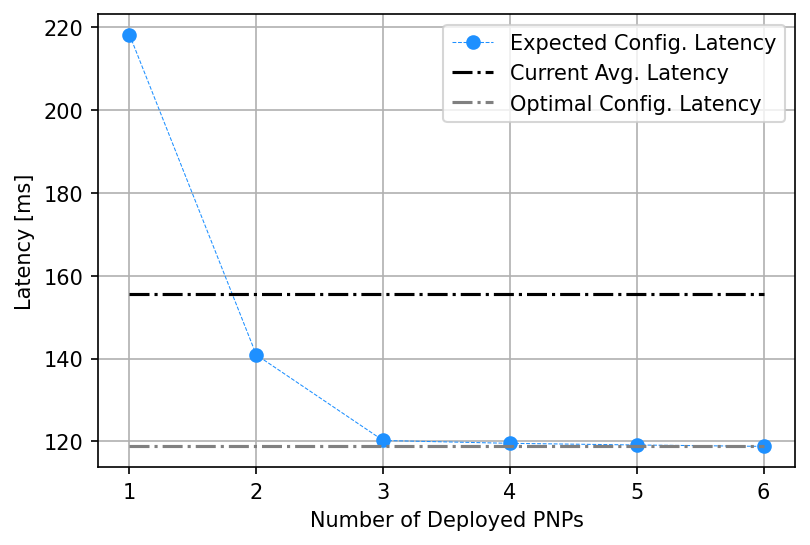

In [60]:
# Plot expected average latency as a function of active gateways

latencies = [best_of_list[k]['mean_network_latency'] for k in best_of_list.keys()]

fig = plt.figure(dpi=150)
plt.plot([a+1 for a in range(gateways_max_deploy)], latencies, '--o', lw=0.5, color='dodgerblue')
plt.ylabel('Latency [ms]')
plt.xlabel('Number of Deployed PNPs')
plt.hlines(current_avg_latency, xmax=gateways_max_deploy, xmin=1, linestyles='-.', colors='black')

plt.hlines(optimal_solution['mean_network_latency'], xmax=gateways_max_deploy, xmin=1, linestyles='-.', colors='grey')


plt.legend(['Expected Config. Latency', 'Current Avg. Latency', 'Optimal Config. Latency'])
plt.grid()

plot_.xaxis.set_major_locator(ticker.LinearLocator(6))

if SAVE_IMAGES:
    plt.draw()
    img_path = os.path.join(OUT_FOLDER, "deploy_to_times.png")
    fig.savefig(img_path, bbox_inches="tight")

plt.show()

plt.close(fig) 


In [61]:
# Create table for reduction
rows = [[key, best_of_list[key]['mean_network_latency'], optimal_solution['mean_network_latency'], current_avg_latency] for key in best_of_list ]
aux_df = pd.DataFrame(rows, columns=['Case', 'Latency', 'Diff. to Optimal', 'Diff. to Current'])
aux_df['Diff. to Current'] = ((aux_df['Latency']-aux_df['Diff. to Current'])/aux_df['Diff. to Current'])*100.
aux_df['Diff. to Optimal'] = ((aux_df['Latency']-aux_df['Diff. to Optimal'])/aux_df['Diff. to Optimal'])*100.
aux_df

,Case,Latency,Diff. to Optimal,Diff. to Current
0,Deploying_1_gateways,218.132492,83.649679,40.135389
1,Deploying_2_gateways,140.886001,18.614465,-9.490262
2,Deploying_3_gateways,120.227531,1.221727,-22.761934
3,Deploying_4_gateways,119.538907,0.641961,-23.204328
4,Deploying_5_gateways,119.141181,0.307109,-23.459840
5,Deploying_6_gateways,118.801590,0.021201,-23.678005


Deploying_1_gateways: 218.13 ms
	eu-central-1


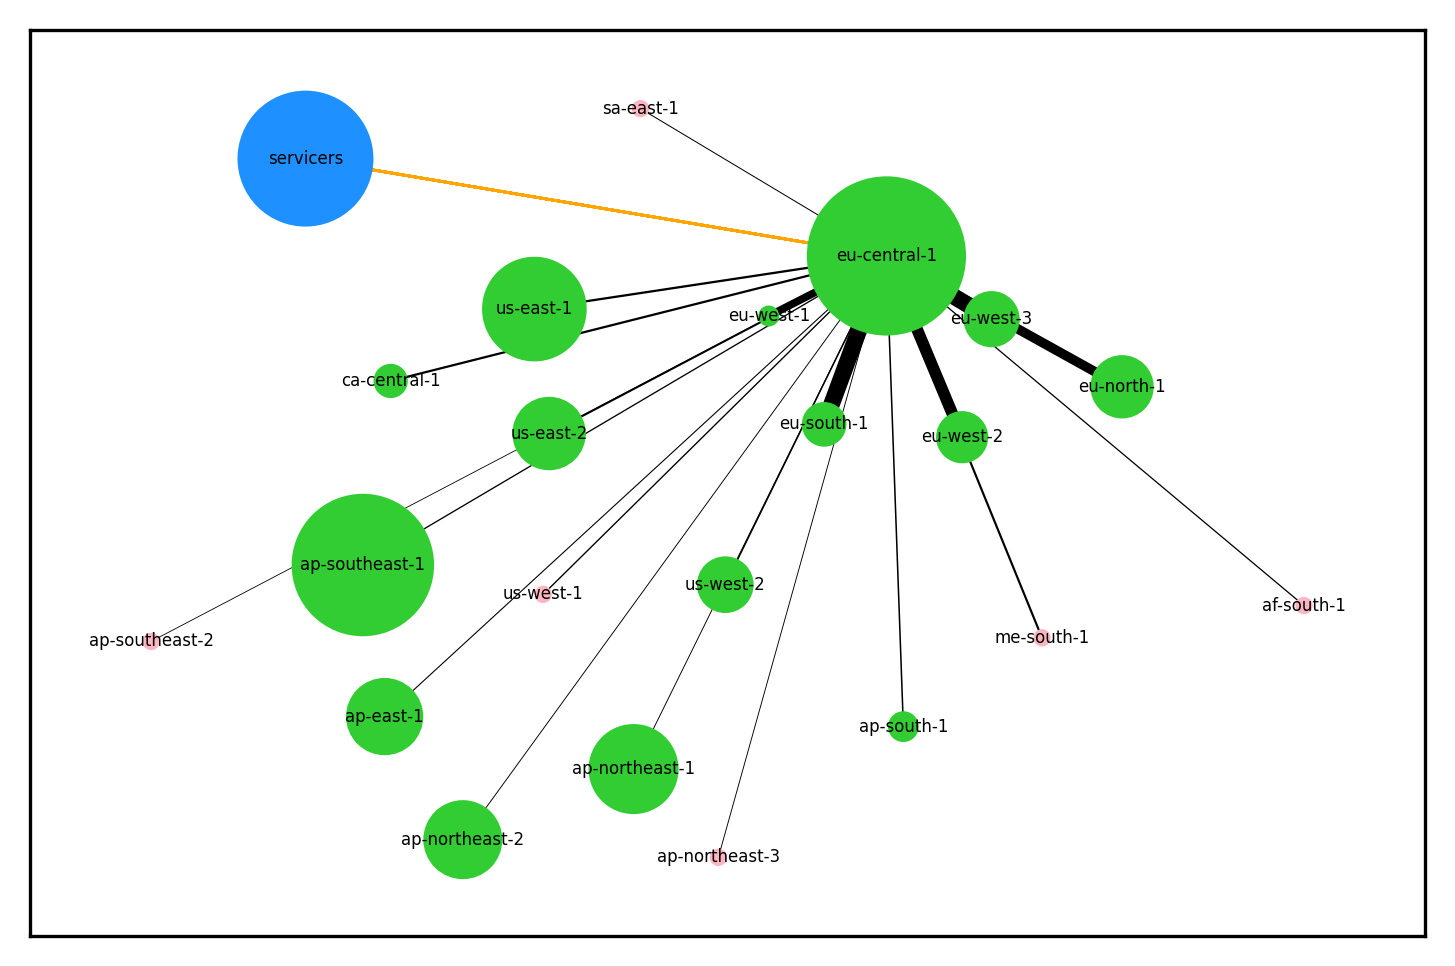

Deploying_2_gateways: 140.89 ms
	ap-southeast-1
	eu-central-1


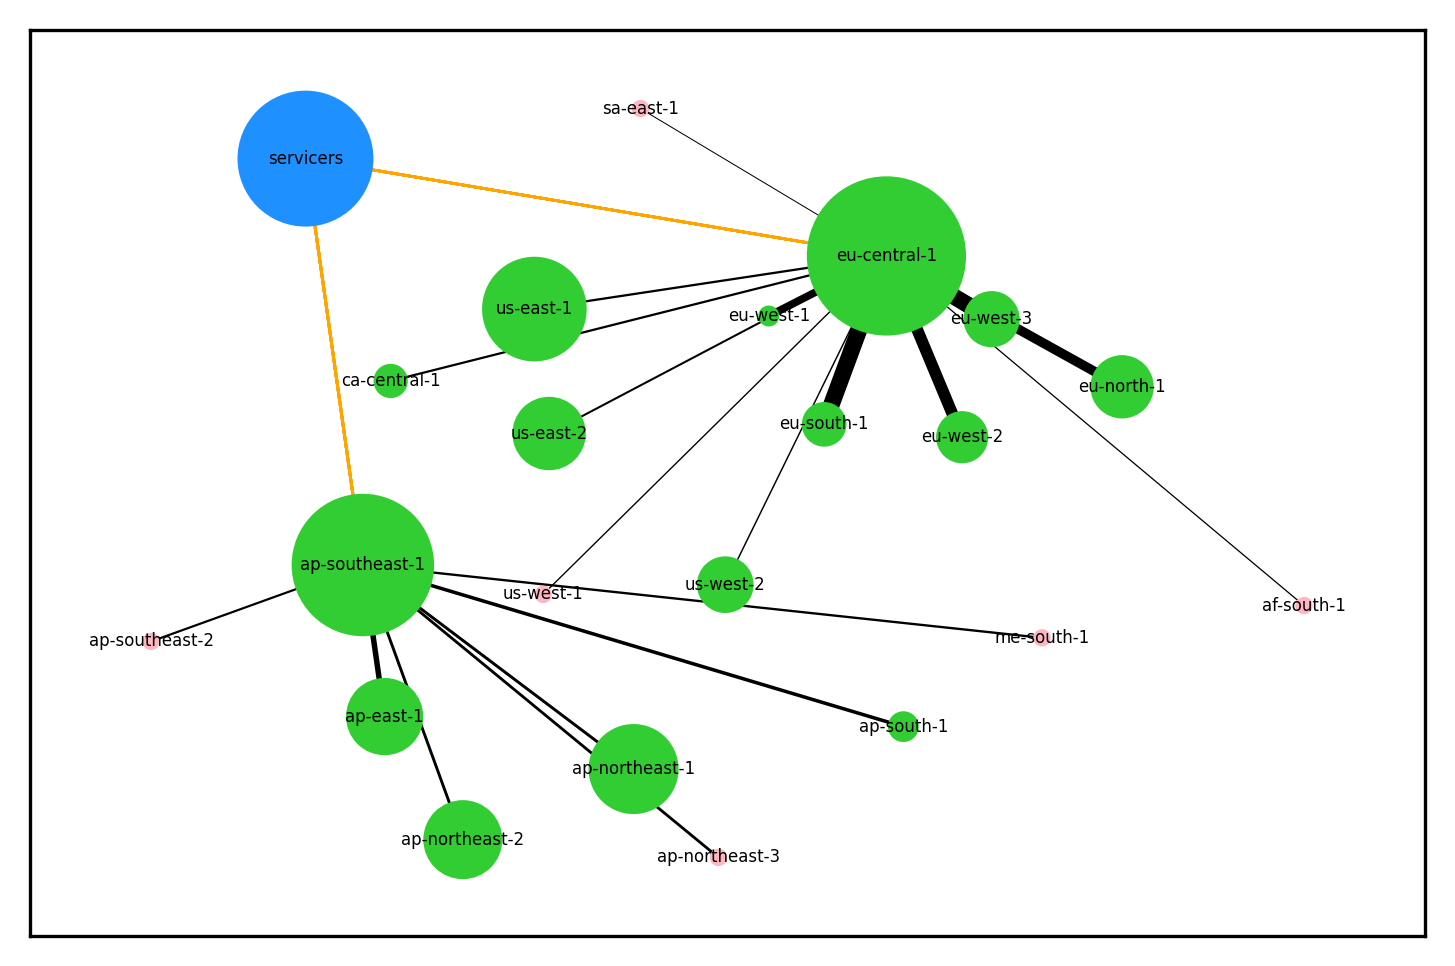

Deploying_3_gateways: 120.23 ms
	ap-southeast-1
	eu-central-1
	us-east-1


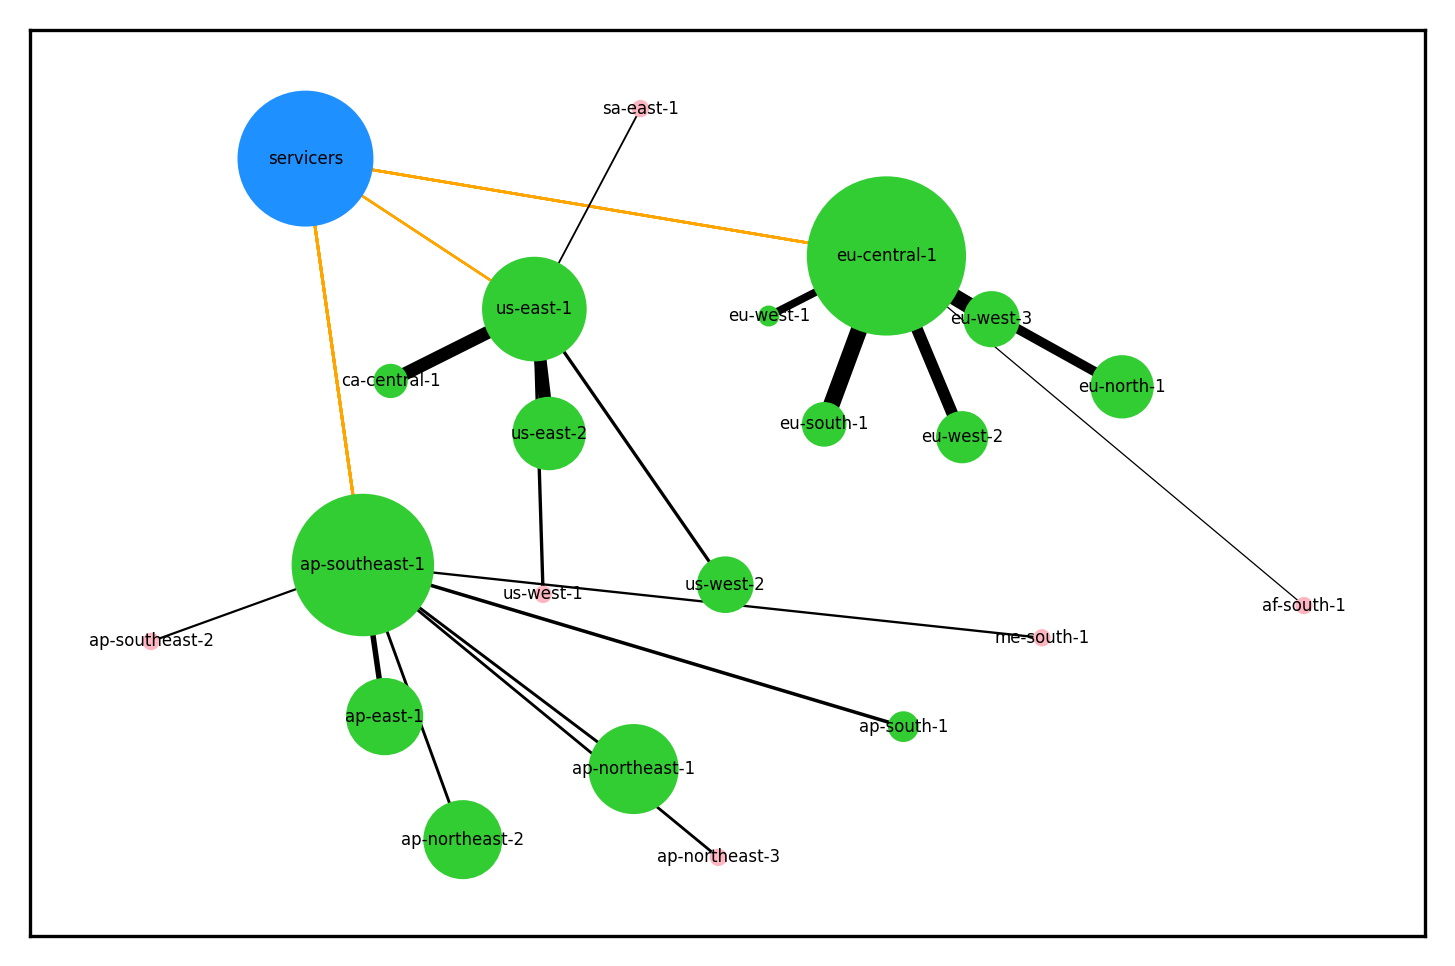

Deploying_4_gateways: 119.54 ms
	ap-southeast-1
	eu-central-1
	us-east-1
	us-east-2


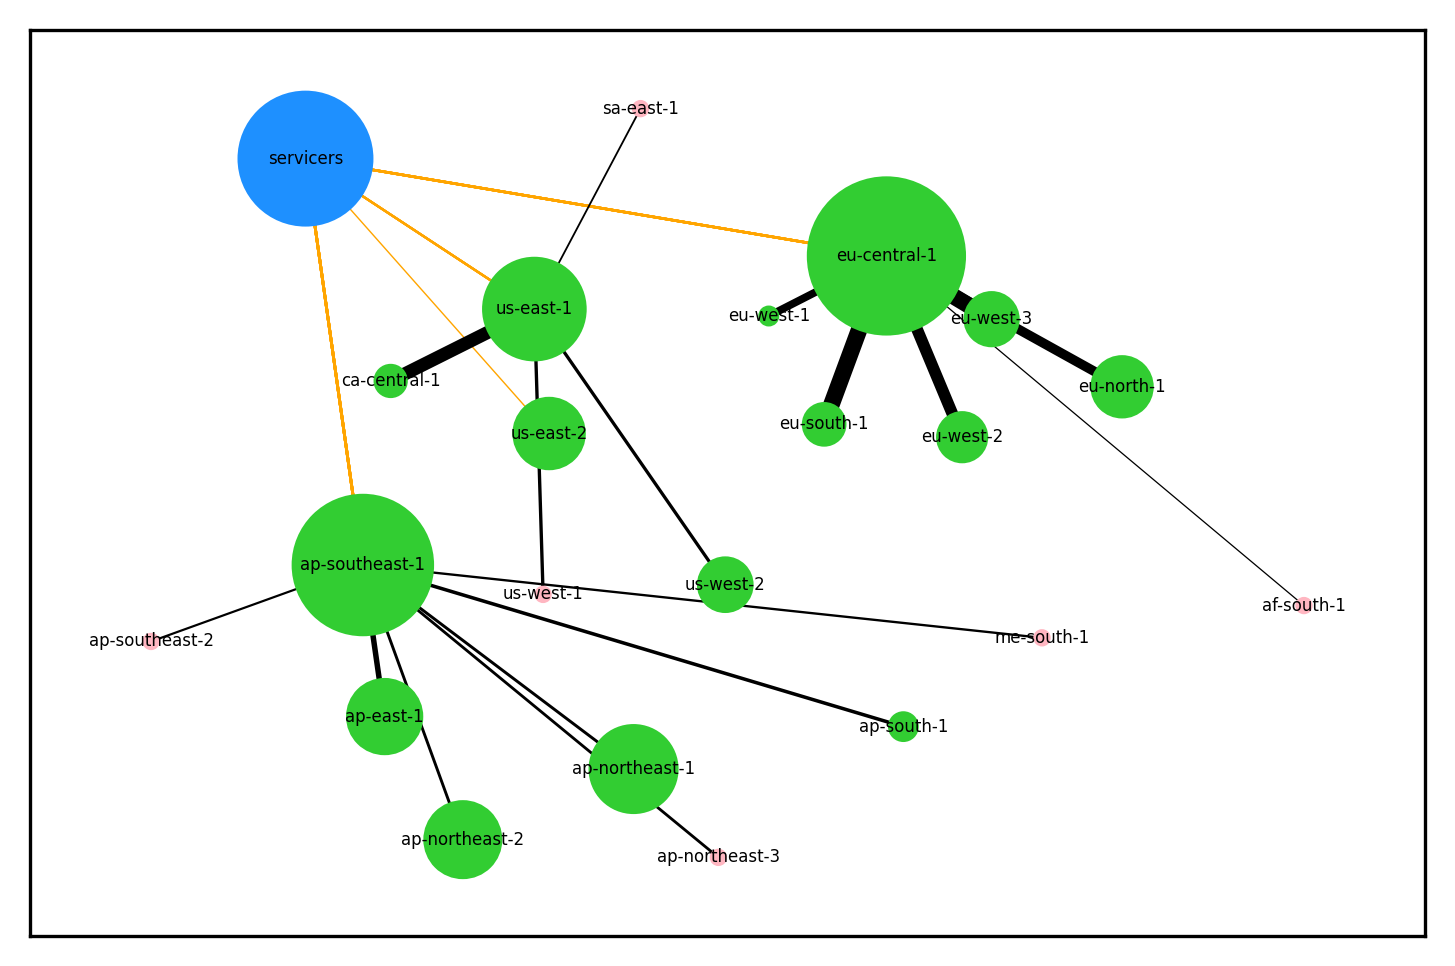

Deploying_5_gateways: 119.14 ms
	ap-southeast-1
	eu-central-1
	eu-west-2
	us-east-1
	us-east-2


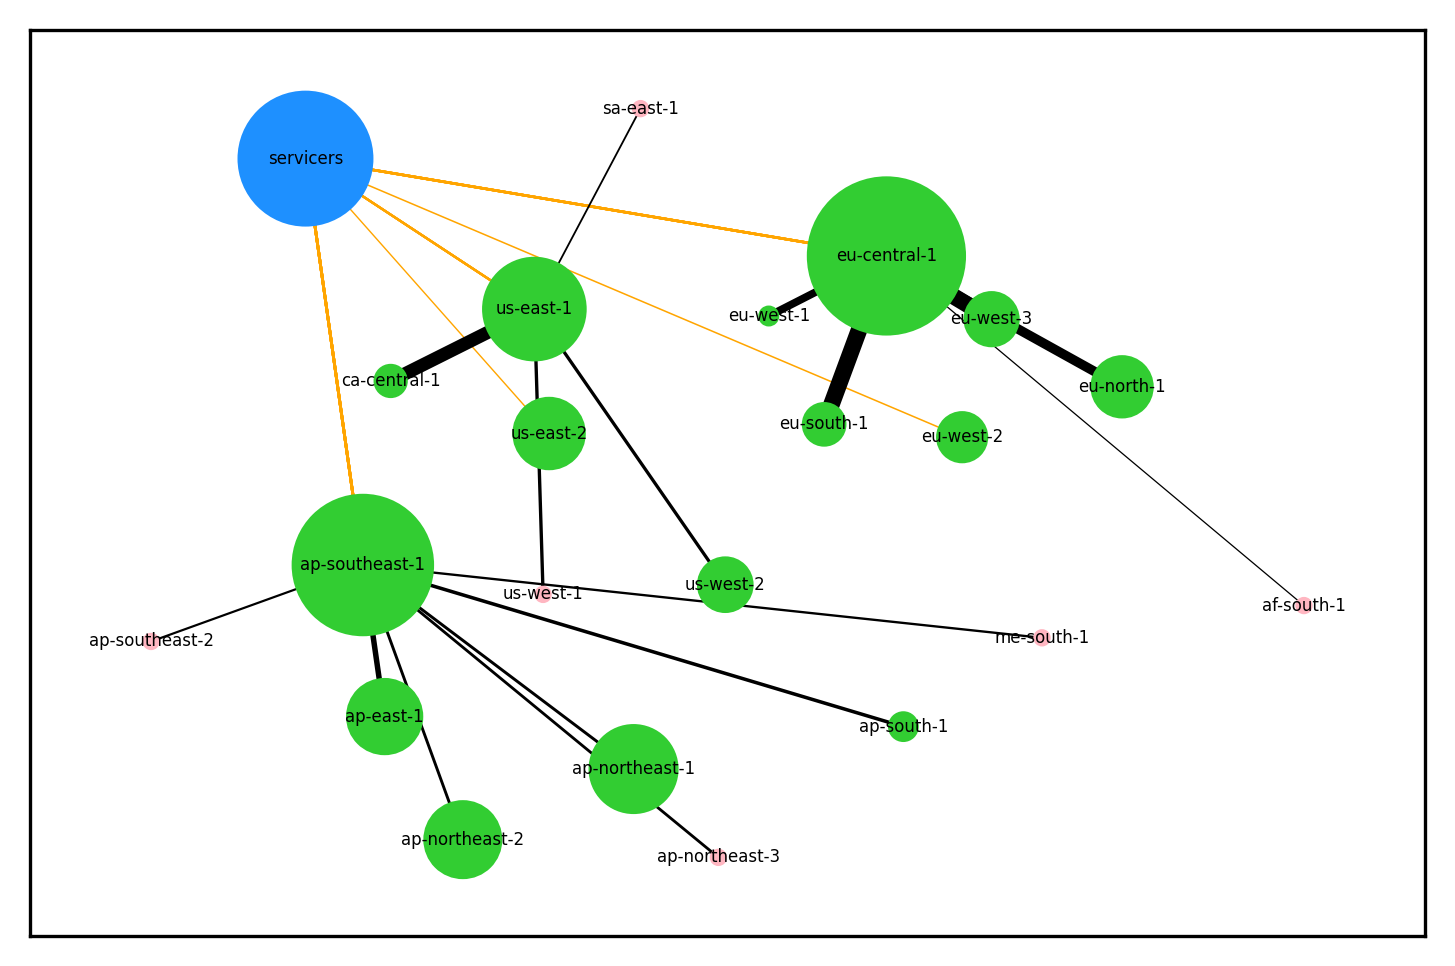

Deploying_6_gateways: 118.80 ms
	ap-southeast-1
	eu-central-1
	eu-west-2
	eu-west-3
	us-east-1
	us-east-2


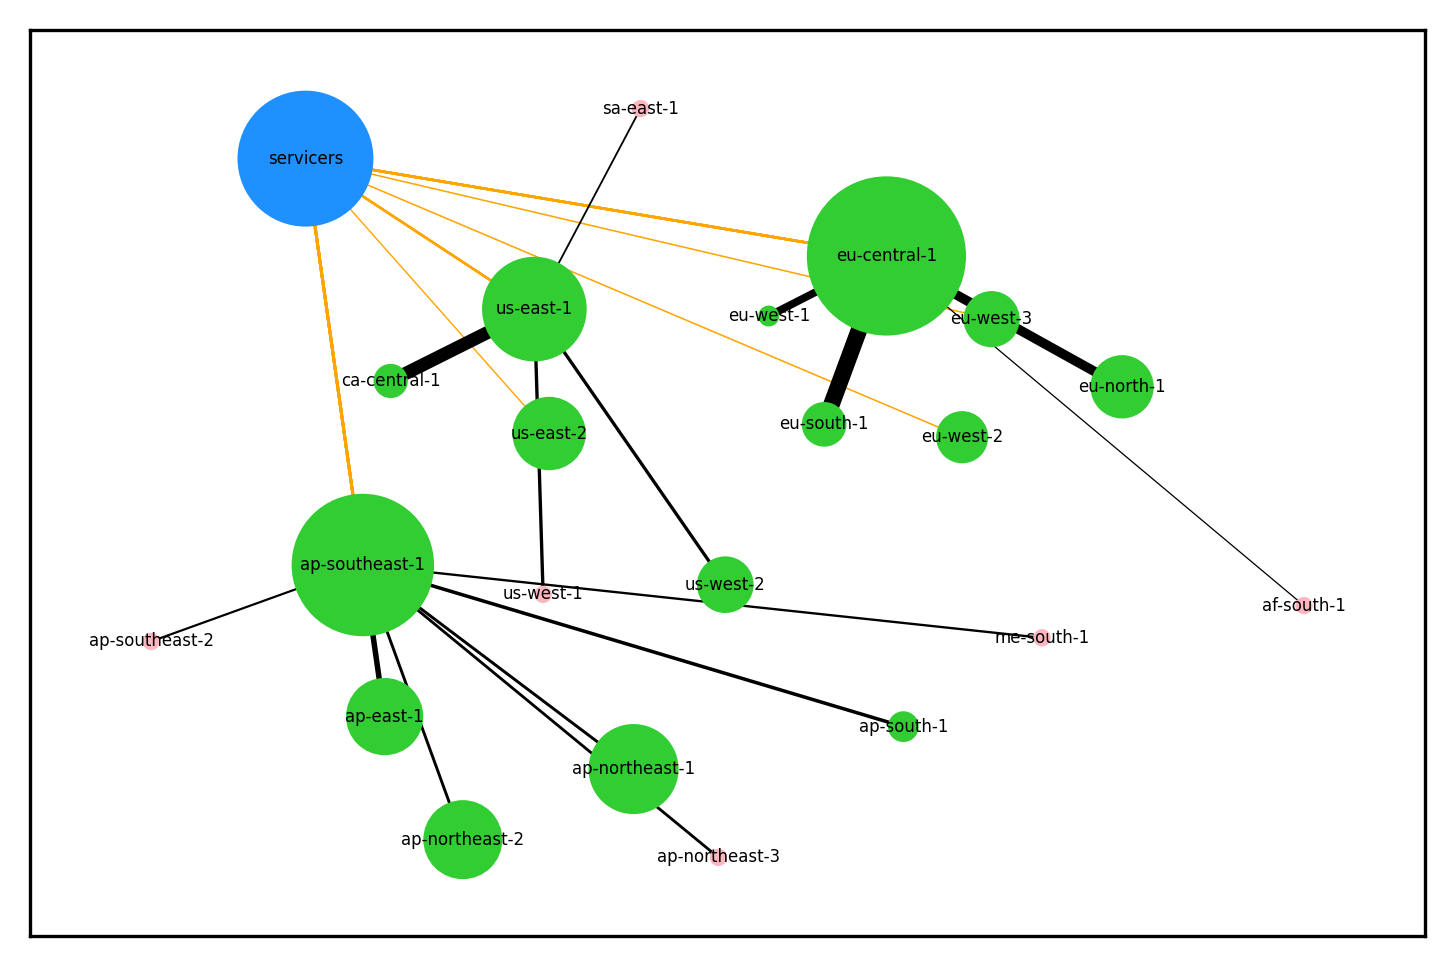

In [62]:
# Plot each configuration routing map

for key in best_of_list:

    aux_G = deepcopy(gateways_graph_base)

    print('%s: %0.2f ms'%(key, best_of_list[key]['mean_network_latency']))
    for gate in best_of_list[key]['gateways']:
        print('\t%s'%gate)

            
        edge_add = loc_ping_dict[gate]
        # Set new edge
        aux_G.add_edge(edge_add, servisers_node,
            weight = lat_dict[edge_add]
            )

    # Calculate shortest paths (bellman-ford / dijkstra)
    short_paths = nx.shortest_path(aux_G, source=None, target=servisers_node, weight=custom_edge_cost, method='dijkstra')

    # Create edges to plot
    edge_widths = list()
    edges_plot = list()
    edges_colors = list()
    for path in short_paths.keys():
        if path == servisers_node:
            continue
        for node_hop in range(1, len(short_paths[path])):
            edges_plot.append((short_paths[path][node_hop-1], short_paths[path][node_hop]))
            edge_widths.append((1./gateways_graph.get_edge_data(short_paths[path][node_hop-1], short_paths[path][node_hop])['weight'])*edge_width_mult)
            if (short_paths[path][node_hop-1]==servisers_node) or (short_paths[path][node_hop]==servisers_node):
                edges_colors.append('orange')
            else:
                edges_colors.append('black')
    
    fig = plt.figure(dpi=300)
    nx.draw_networkx(gateways_graph, 
                     edgelist=edges_plot, 
                     pos=pos_draw, 
                     labels=labels, 
                     node_size=node_sizes, 
                     node_color=node_colors, 
                     edge_color = edges_colors,
                     width=edge_widths, 
                     with_labels=True, 
                     font_size=4)

    if SAVE_IMAGES:                     
        plt.box(False)

        plt.draw()
        img_path = os.path.join(OUT_FOLDER, "network_%s.png"%key)
        fig.savefig(img_path, bbox_inches="tight")

    plt.show()

    plt.close(fig) 

    

Optimal solution: 118.78 ms
	ap-southeast-1
	eu-central-1
	us-west-2
	ap-east-1
	us-east-2
	eu-west-2
	eu-west-3
	us-east-1


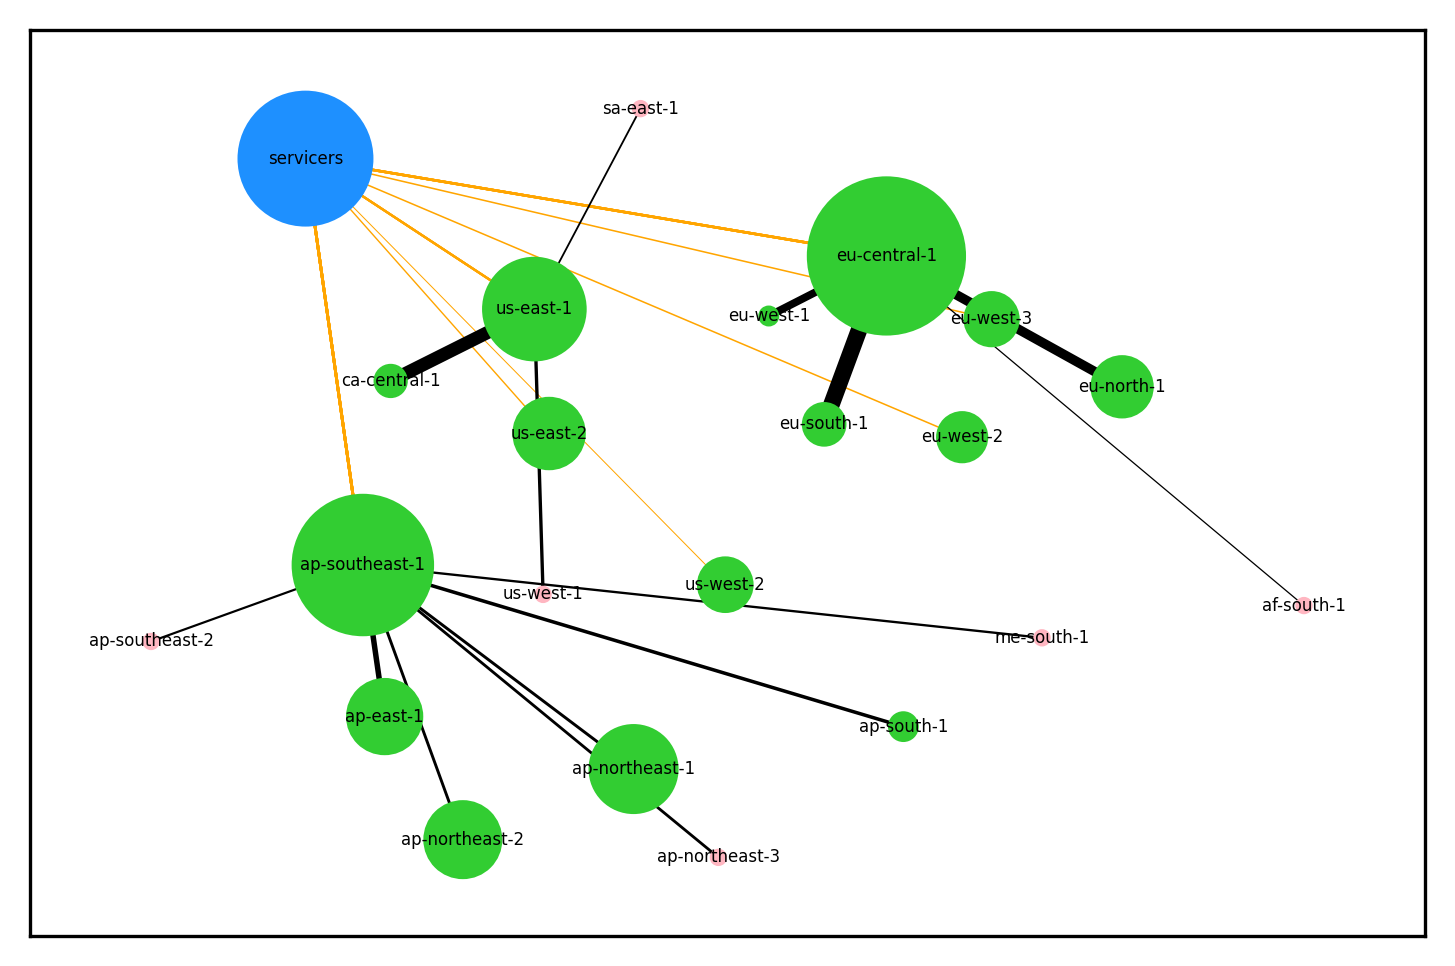

In [63]:
aux_G = deepcopy(gateways_graph_base)

print('Optimal solution: %0.2f ms'%(optimal_solution['mean_network_latency']))
for gate in optimal_solution['gateways']:
    print('\t%s'%gate)

        
    edge_add = loc_ping_dict[gate]
    # Set new edge
    aux_G.add_edge(edge_add, servisers_node,
        weight = lat_dict[edge_add]
        )

# Calculate shortest paths (bellman-ford / dijkstra)
short_paths = nx.shortest_path(aux_G, source=None, target=servisers_node, weight=custom_edge_cost, method='dijkstra')

# Create edges to plot
edge_widths = list()
edges_plot = list()
edges_colors = list()
for path in short_paths.keys():
    if path == servisers_node:
        continue
    for node_hop in range(1, len(short_paths[path])):
        edges_plot.append((short_paths[path][node_hop-1], short_paths[path][node_hop]))
        edge_widths.append((1./gateways_graph.get_edge_data(short_paths[path][node_hop-1], short_paths[path][node_hop])['weight'])*edge_width_mult)

        if (short_paths[path][node_hop-1]==servisers_node) or (short_paths[path][node_hop]==servisers_node):
            edges_colors.append('orange')
        else:
            edges_colors.append('black')
        

fig = plt.figure(dpi=300)

nx.draw_networkx(gateways_graph, 
                    edgelist=edges_plot, 
                    pos=pos_draw, 
                    labels=labels, 
                    node_size=node_sizes, 
                    node_color=node_colors, 
                    width=edge_widths, 
                    edge_color = edges_colors,
                    with_labels=True, 
                    font_size=4)

if SAVE_IMAGES:
    plt.box(False)

    plt.draw()
    img_path = os.path.join(OUT_FOLDER, "network_optimal.png")
    fig.savefig(img_path, bbox_inches="tight")

plt.show()

plt.close(fig) 

    